In [1]:
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
%pylab inline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.regression import mean_squared_error
from sklearn.metrics import classification_report,r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression, LassoCV, Lasso 

Populating the interactive namespace from numpy and matplotlib


/Users/aaa/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
xls_file = pd.ExcelFile('retail_vol_ccy_w_rt_cpi.xlsx')
df = xls_file.parse('Total')
df.head()

,Date,vol_tot,vol_rub,vol_ccy,expo_tot,expo_rub,expo_ccy,npl_tot,npl_rub,npl_ccy,...,d_wage,rt3m,d_rt3m,dGPD,f_dec,f_jan,unp,d_unp,cpi,d_cpi
0,2009-04-01,456779.2,424697.2,32082.0,3848399.0,3341053.6,507345.4,180597.6,155980.0,24617.6,...,0.000000,16.53,0.00,-0.035002,0,0,8.3,0.0,100.7,0.0
1,2009-05-01,228701.0,216410.3,12290.7,3791289.5,3300033.5,491256.0,193421.9,166553.5,26868.4,...,-0.000111,16.04,-0.49,-0.035002,0,0,8.3,0.0,100.6,-0.1
2,2009-06-01,221268.3,212818.6,8449.7,3722873.1,3266609.3,456263.8,202671.2,176069.2,26602.0,...,0.068862,12.49,-3.55,-0.035002,0,0,8.3,0.0,100.6,0.0
3,2009-07-01,266435.9,256395.6,10040.3,3683033.9,3232124.6,450909.3,209446.2,182799.5,26646.7,...,-0.019484,11.81,-0.68,-0.065562,0,0,8.3,0.0,100.6,0.0
4,2009-08-01,232492.2,221958.4,10533.8,3667260.9,3218173.3,449087.6,217713.4,190062.3,27651.1,...,-0.028455,11.89,0.08,-0.065562,0,0,8.3,0.0,100.0,-0.6


In [75]:
df['d_rubusd'][102] = 0
df['d_rubusd'][102] 

0.0

In [76]:
df['f_dec'].value_counts()

0    95
1     8
Name: f_dec, dtype: int64

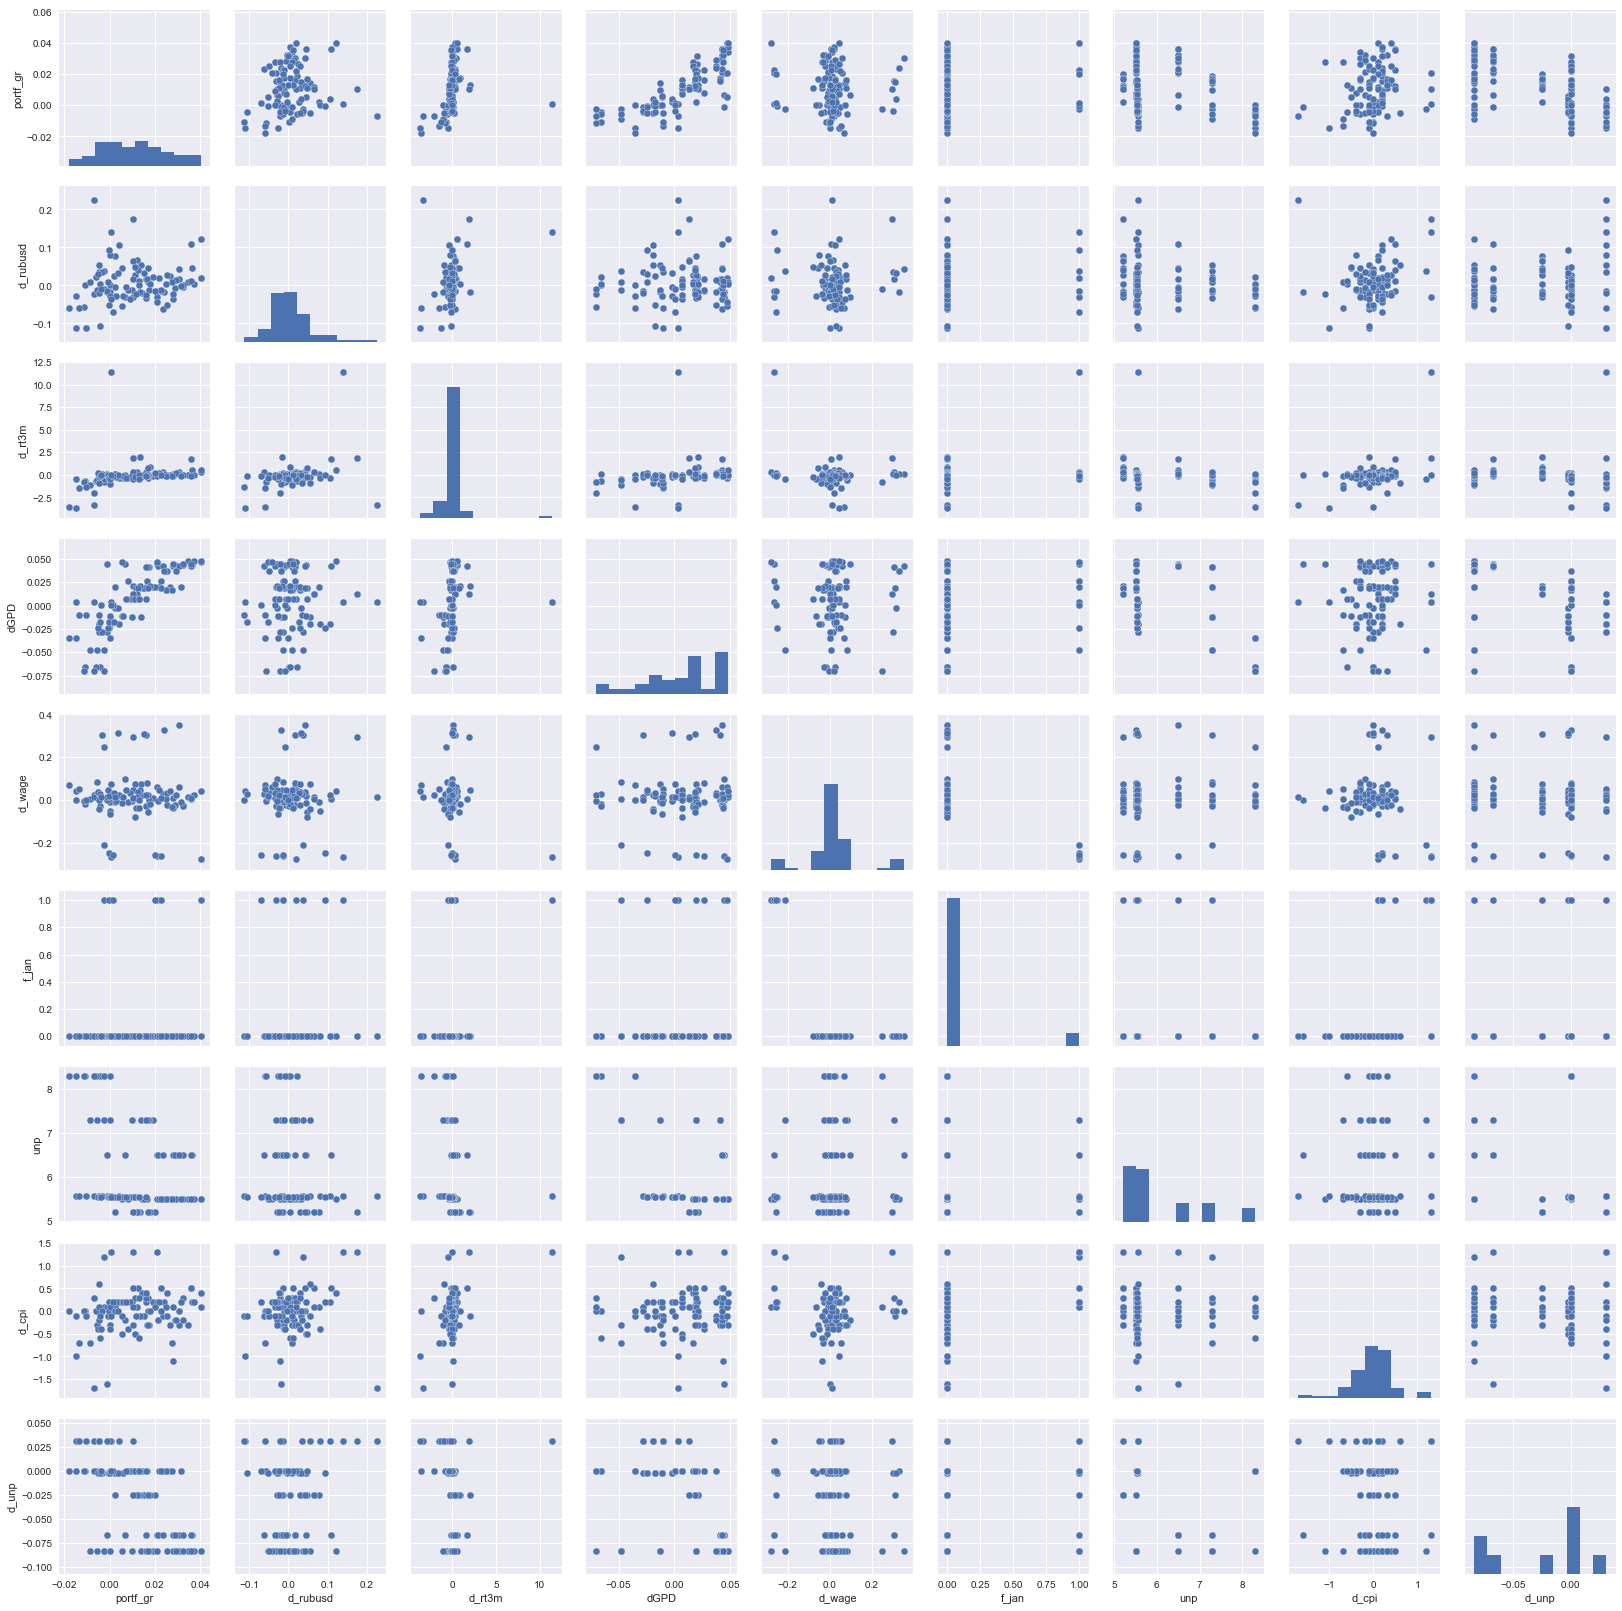

In [185]:
sns.pairplot(
    df[['portf_gr','d_rubusd','d_rt3m','dGPD','d_wage','f_jan','unp' ,'d_cpi','d_unp']]);

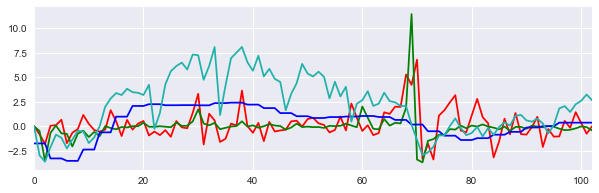

In [195]:
figsize(10, 3)
plt.plot(df['d_rubusd']*30 ,c = 'red')
plt.plot(df['d_rt3m'],c = 'green')
plt.plot(df['dGPD']*50,c = 'blue')
plt.plot(df['portf_gr']*200,c = 'lightseagreen')
plt.xlim((0, 102))
plt.show()

In [217]:
predictors = list(set(['d_rubusd','d_rt3m','dGPD','unp','f_dec','d_cpi']))#'wage',,'f_dec','f_jan','d_wage'

In [ ]:
df.plot(x='Date', y=['d_rt3m','portf_gr','d_rubusd','dGPD'], kind='line')
plt.show()


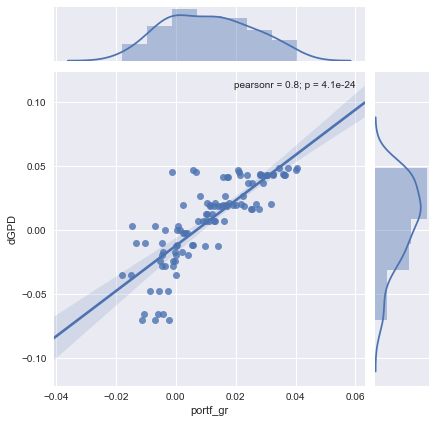

In [82]:
sns.jointplot(x='portf_gr', y='dGPD', 
              data=df, kind='reg')

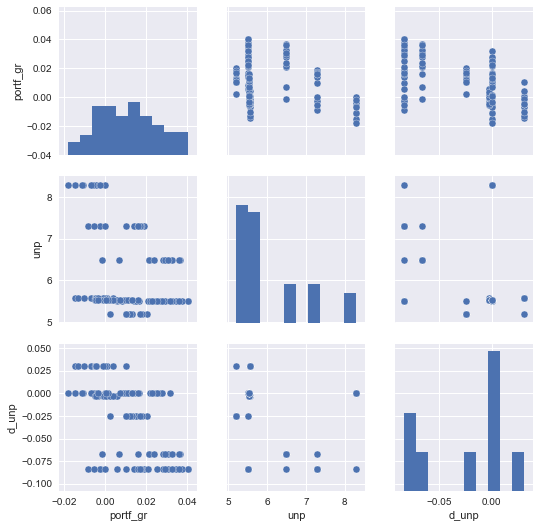

In [186]:
sns.pairplot(
    df[['portf_gr','unp' ,'d_unp']]);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120153240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ed1ea20>]], dtype=object)

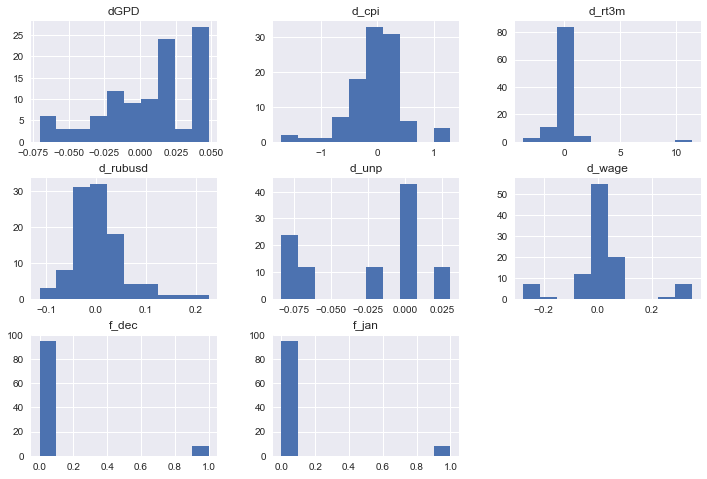

In [83]:
figsize(12, 8)
df[predictors].hist()

In [75]:
#Пока берем в качестве обучающей выборки всю выборку
#X_train = df[predictors]
#y_train = df['portf_gr']

#X_test = df[predictors].copy()
#y_test = df['portf_gr'].copy()

Смотрим на корреляции признаков

In [135]:
corr = df[predictors].corr()
corr

,d_rubusd,d_unp,d_rt3m,d_cpi,f_dec,dGPD
d_rubusd,1.000000,0.086660,0.329709,0.146594,0.179132,0.038760
d_unp,0.086660,1.000000,-0.026600,-0.027143,-0.016304,-0.456557
d_rt3m,0.329709,-0.026600,1.000000,0.426735,0.061294,0.216277
d_cpi,0.146594,-0.027143,0.426735,1.000000,0.143649,0.024816
f_dec,0.179132,-0.016304,0.061294,0.143649,1.000000,-0.005812
dGPD,0.038760,-0.456557,0.216277,0.024816,-0.005812,1.000000


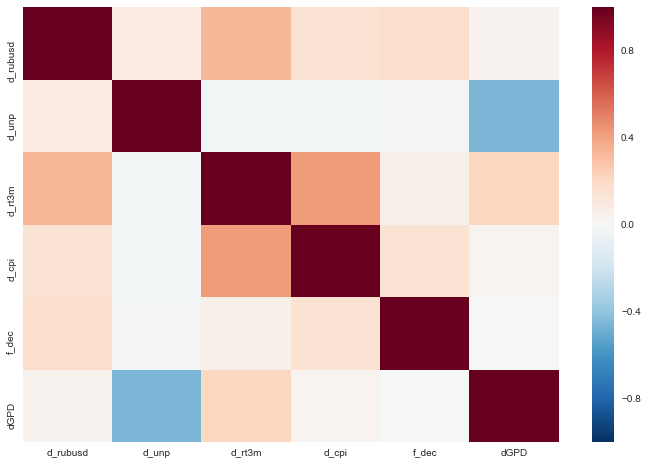

In [136]:
sns.heatmap(corr);

Разбиваем на обучающую и тестовую выборки

In [218]:
X_train,X_test,y_train,y_test =train_test_split(df[predictors]
                                                ,df['portf_gr'],random_state=42)
X_total = df[predictors]
y_total = df['portf_gr']

Случайный лес, важность признаков

In [219]:
forest = RandomForestRegressor(n_estimators=500, max_depth = 5,
                                random_state=42).fit(X_train, y_train)

features = pd.DataFrame(forest.feature_importances_,
                        index=X_train.columns,columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
test_pred = forest.predict(X_test)
features

,Importance
dGPD,0.780193
d_rt3m,0.104089
d_rubusd,0.072789
unp,0.025875
d_cpi,0.016359
f_dec,0.000695


Точность на обучающей и тестовой выборках

In [220]:
forest.score(X_train, y_train)

0.96143105927978645

In [221]:
forest.score(X_test, y_test)

0.73919849216486244

MSE

In [222]:
print(mean_squared_error(forest.predict(X_train), y_train))
print(cross_val_score(forest, X_train, y_train, scoring='neg_mean_squared_error'))
print(abs(np.mean(cross_val_score(forest, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1))))
print(abs(np.mean(cross_val_score(forest, X_test, y_test, scoring='neg_mean_squared_error', n_jobs=-1))))

8.11318070669e-06
[ -4.13702780e-05  -4.19540292e-05  -5.18241139e-05]
4.50494737234e-05
8.43770917558e-05


Нормируем выборку

In [223]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_tot_scaled = scaler.fit_transform(X_total)

In [224]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head()

,d_rubusd,d_rt3m,unp,d_cpi,f_dec,dGPD
0,0.195415,-0.128783,1.314340,-0.073293,-0.290701,0.438226
1,-2.277398,-0.770197,-0.508517,-0.308443,-0.290701,-0.500494
2,-0.110381,0.050813,-0.579416,0.632156,-0.290701,1.214001
3,0.607947,-0.224995,1.314340,2.748505,-0.290701,-1.678741
4,-2.144738,-0.019742,-0.540282,-0.308443,-0.290701,-0.723520


In [ ]:
X_train_scaled.hist()

In [225]:
linregsc = LinearRegression(n_jobs=-1)
linreg = LinearRegression(n_jobs=-1)
linregsc.fit(X_train_scaled, y_train)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [226]:
print(mean_squared_error(linregsc.predict(X_train_scaled), y_train))
print(r2_score(y_train,linregsc.predict(X_train_scaled)))
print(r2_score(y_test,linregsc.predict(X_test_scaled)))

6.56083100952e-05
0.688107153742
0.656437166485


In [204]:
linreg_coef = pd.DataFrame(np.c_[linregsc.coef_, np.abs(linregsc.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
linreg_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
dGPD,0.009653,0.009653
d_unp,-0.003702,0.003702
d_rubusd,0.002051,0.002051
d_cpi,0.001789,0.001789
f_dec,-0.000303,0.000303
d_rt3m,-0.000242,0.000242


In [205]:
linregsc.intercept_

0.010220935761504499

In [102]:
test_l_pred = linreg.predict(X_test)

In [103]:
test_l_pred_sc = linregsc.predict(X_test_scaled)

In [180]:
pred_total = linregsc.predict(X_tot_scaled)
pred_total_forest = forest.predict(X_total)

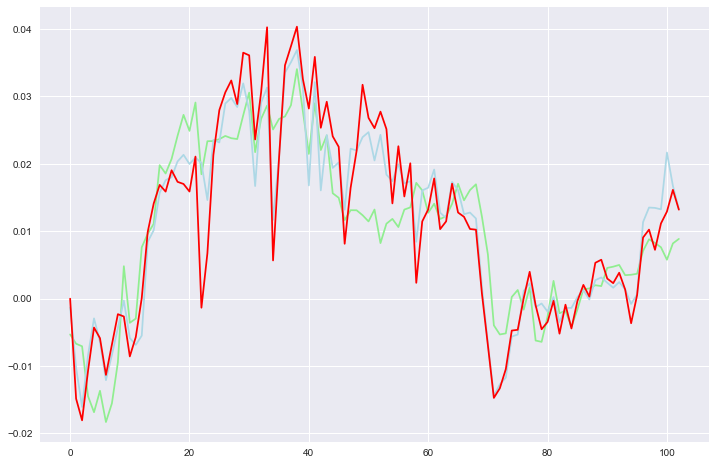

In [181]:
plt.plot(pred_total, label='linreg', c='lightgreen')
plt.plot(pred_total_forest, label='linreg', c='lightblue')
plt.plot(y_total, label='Actual', c='red')

In [182]:
print(mean_squared_error(forest.predict(X_total), y_total))
print(mean_squared_error(linregsc.predict(X_tot_scaled), y_total))

1.75119714254e-05
5.78869178506e-05


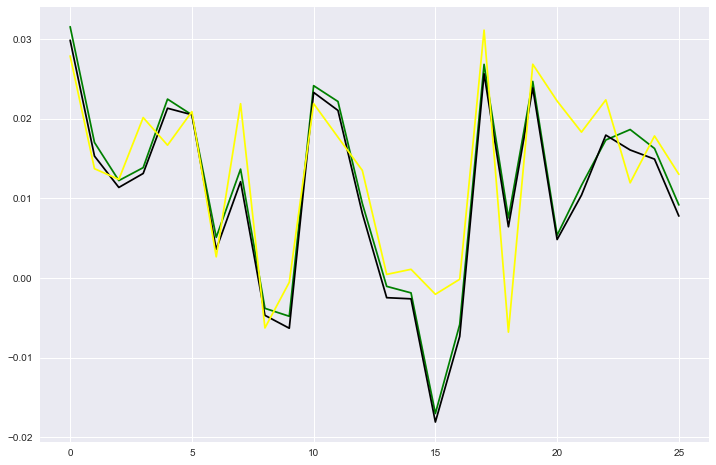

In [144]:
plt.plot(test_l_pred, label='linreg', c='green')
plt.plot(test_l_pred_sc, label='Scaled', c='black')
plt.plot(test_pred, label='forest', c='yellow')
#plt.plot(pred_total, label='forest', c='red')
#plt.plot(y_test, label='Actual', c='red')
plt.show()    
    